## Simulation of  modified Stuart-Landau (MSL) model with (generalized) phase model

### Setup

In [1]:
using GeneralizedPhaseReduction
using DifferentialEquations, PyPlot
using PyCall
using ProgressMeter
axes_grid1 = pyimport("mpl_toolkits.axes_grid1")

┌ Info: Precompiling GeneralizedPhaseReduction [10598a1f-f994-49a4-9c73-198b90050674]
└ @ Base loading.jl:1423


PyObject <module 'mpl_toolkits.axes_grid1' from 'C:\\Users\\yamta\\miniconda3\\lib\\site-packages\\mpl_toolkits\\axes_grid1\\__init__.py'>

In [141]:
plt.rc("text", usetex=true)
PyCall.PyDict(plt."rcParams")["font.size"] = 14
PyCall.PyDict(plt."rcParams")["xtick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["ytick.direction"] = "in"
PyCall.PyDict(plt."rcParams")["xtick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["ytick.minor.visible"] = true
PyCall.PyDict(plt."rcParams")["xtick.top"] = true 
PyCall.PyDict(plt."rcParams")["ytick.right"] = true 
PyCall.PyDict(plt."rcParams")["font.family"] = "Arial"
PyCall.PyDict(plt."rcParams")["text.latex.preamble"] = [raw"\usepackage{amsmath}"];

### Model definition

In [2]:
# Parameters and variables
c = 0.7; d = 0.8; eps = 0.08; # FHN parameters

# FHN vector field
dvdt(X, I) = X[1] - X[1]^3/3.0 - X[2] + I + 0.875
dudt(X) = eps * (X[1] + c - d * X[2])
F(X, I) = [dvdt(X, I), dudt(X)]

D, N = 2, 2 # number of dimensions, units
Nθ = 1000
G(X, K) = K * ([-1 1; 1 -1] * X[:, 1])
dt = 1e-3; T = 150.0; Nt = round(Int, T/dt)

150000

In [3]:
@time Ts, ω, Xs = find_stable_periodic_solution(F, 0, D, Nθ, [2, 0.5], dt, Tsit5(), 1, 0.0, print_progress=false)
println("Ts=", Ts, " (sec) , ω=", ω, " (Hz)")

  7.211432 seconds (32.46 M allocations: 1.693 GiB, 7.93% gc time, 92.39% compilation time)
Ts=36.419000000000004 (sec) , ω=0.1725249267464671 (Hz)


In [4]:
# F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr
ωI, ζθI, ξθI, XsI = generalized_phase_sensitivity_func(F, -0.55, 0.55, 0.01, D, Nθ, nothing, dt, Tsit5(), 1, 0.0);

[1/3] Computing Xs(θ, I) and Z(θ, I)...100%|████████████| Time: 0:01:21


[2/3] Computing ζ(θ, I)...
[3/3] Computing ξ(θ, I)...


In [5]:
function coupled_func!(dX, X, p, t)
    g, κ = p
    Iext = g(X) # input
    for i in 1:size(dX)[1]
        dX[i, :] = κ[i] * F(X[i, :], Iext[i])
    end
end

coupled_func! (generic function with 1 method)

If `K>0.10`, IΘ cannot be computed because it's outside the range of external forces that can produce a stable periodic orbit.

In [87]:
alg = Tsit5()
NΘ = 50
K = 0.10 
κ = [1.0, 1.5]
initθ = [0, π/2];
g(X) = G(X, K)

g (generic function with 1 method)

In [77]:
QΘ = compute_QΘ(g, N, D, XsI, κ, ωI, NΘ);

Computing P(θ₁, θ₂)...100%|█████████████████████████████| Time: 0:00:13


In [69]:
Θrange = range(0, 2π, length=100);
QΘmap = QΘ[1](Θrange, Θrange);

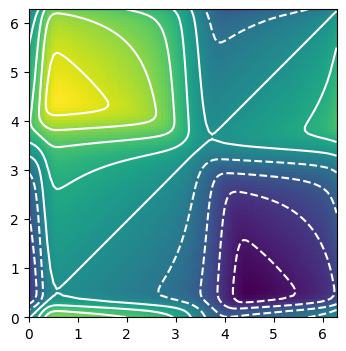

PyObject <matplotlib.image.AxesImage object at 0x00000000C7A79FD0>

In [70]:
figure(figsize=(4, 4))
contour(Θrange, Θrange, QΘmap, 10, colors="white")
imshow(reverse(QΘmap, dims=1), extent=(0, 2pi, 0, 2pi))

In [71]:
PΘmap = zeros(100, 100);

for k in 1:100
    for l in 1:100
        Θ = [Θrange[k], Θrange[l]]
        PΘmap[k, l] = g(hcat([[XsI[j](Θ[i], QΘmap[k, l]) for j in 1:D] for i in 1:N]...)')[1] - QΘmap[k, l]
    end
end; 

### Run simulation

In [88]:
Tos, Xos, _, _ = coupled_original_system(N, D, T, XsI, g, coupled_func!, initθ, κ, alg);
Tcpm, Xcpm, Θcpm = coupled_conventinal_phase_model(N, D, T, XsI, g, ωI, ζθI, initθ, κ, alg);

In [89]:
Tgpm, Xgpm, Θgpm = coupled_generalized_phase_model_PQ(N, D, T, XsI, QΘ, ωI, ζθI, ξθI, initθ, κ, g, alg);

In [13]:
Irange = -0.55:0.01:0.55; 

In [14]:
cm = get_cmap(:tab20)

In [90]:
ωt1os, ωt1cpm, ωt1gpm = (κ[1] * ω) .* Tos, (κ[1] * ω) .* Tcpm, (κ[1] * ω) .* Tgpm;
ωt2os, ωt2cpm, ωt2gpm = (κ[2] * ω) .* Tos, (κ[2] * ω) .* Tcpm, (κ[2] * ω) .* Tgpm;
Δωtos, Δωtcpm, Δωtgpm,  = ωt2os - ωt1os, ωt2cpm - ωt1cpm, ωt2gpm - ωt1gpm;

In [17]:
function update!(dX, X, p, t)
    dX[:] = F(X, p)
end

update! (generic function with 1 method)

In [18]:
function truncated_fourier_averages(initX, input_param, T₀, num_total=4, num_relax=2, dt=1e-3, display=false)
    numT₀ = round(Int, T₀/dt)
    NT = round(Int, num_total*numT₀) # total time
    NREL = round(Int, num_relax*numT₀) # relax
    time = range(0, num_total*T₀, length=NT)
    ω₀ = 2pi / T₀
    D = size(initX)[1]
    
    integrator = get_ode_integrator(update!, initX, dt, input_param, Tsit5())
    Xrec = zeros(D, NT) # recording array
    
    for tt in 1:NT
        Xrec[:, tt] = integrator.u
        step!(integrator, dt, true)
    end
    
    if display
        figure(figsize=(3,3))
        plot(Xrec[1, :], Xrec[2, :])
        tight_layout()
    end
    
    # cis(x) = exp(ix) 
    f = sum(Xrec[1, NREL:NT] .* cis.(-ω₀*time[NREL:NT]) * dt) / (num_total-num_relax)*T₀
    phase = angle.(f)
    return f, phase
end

truncated_fourier_averages (generic function with 4 methods)

In [19]:
function conventional_tfa(X, N, Ts, num_total, num_relax, dt)
    Θfa = zeros(size(X)[1:2])
    @showprogress for i in 1:size(X)[1]
        for j in 1:N
            _, θ = truncated_fourier_averages(X[i, j, :], 0, Ts, num_total, num_relax, dt)
            Θfa[i, j] = θ
        end
    end
    Θfa = phase2cum_phase(Θfa, N);
    return Θfa
end

conventional_tfa (generic function with 1 method)

In [20]:
size(Xos)[1:2]

(8337, 2)

In [59]:
Θcfa = conventional_tfa(Xos, N, Ts, 4, 2, 5dt);

Progress: 100%|█████████████████████████████████████████| Time: 0:13:48


In [93]:
for i in 1:2
    Θcfa[:, i] = Θcfa[:, i] .- Θcfa[1, i] .+ initθ[i]
end

In [22]:
function generalized_tfa(X, N, g, ωI, num_total, num_relax, dt)
    Θfa = zeros(size(X)[1:2])
    @showprogress for i in 1:size(X)[1]
        Iex = g(X[i, :, :])
        TsI = 2pi ./ ωI.(Iex)
        for j in 1:N
            _, θ = truncated_fourier_averages(X[i, j, :], Iex[j], TsI[j], num_total, num_relax, dt)
            Θfa[i, j] = θ
        end
    end
    Θfa = phase2cum_phase(Θfa, N);
    return Θfa
end

generalized_tfa (generic function with 1 method)

In [60]:
Θgfa = generalized_tfa(Xos, N, g, ωI, 4, 2, 5dt);

Progress: 100%|█████████████████████████████████████████| Time: 0:13:59


In [94]:
for i in 1:2
    Θgfa[:, i] = Θgfa[:, i] .- Θgfa[1, i] .+ initθ[i]
end

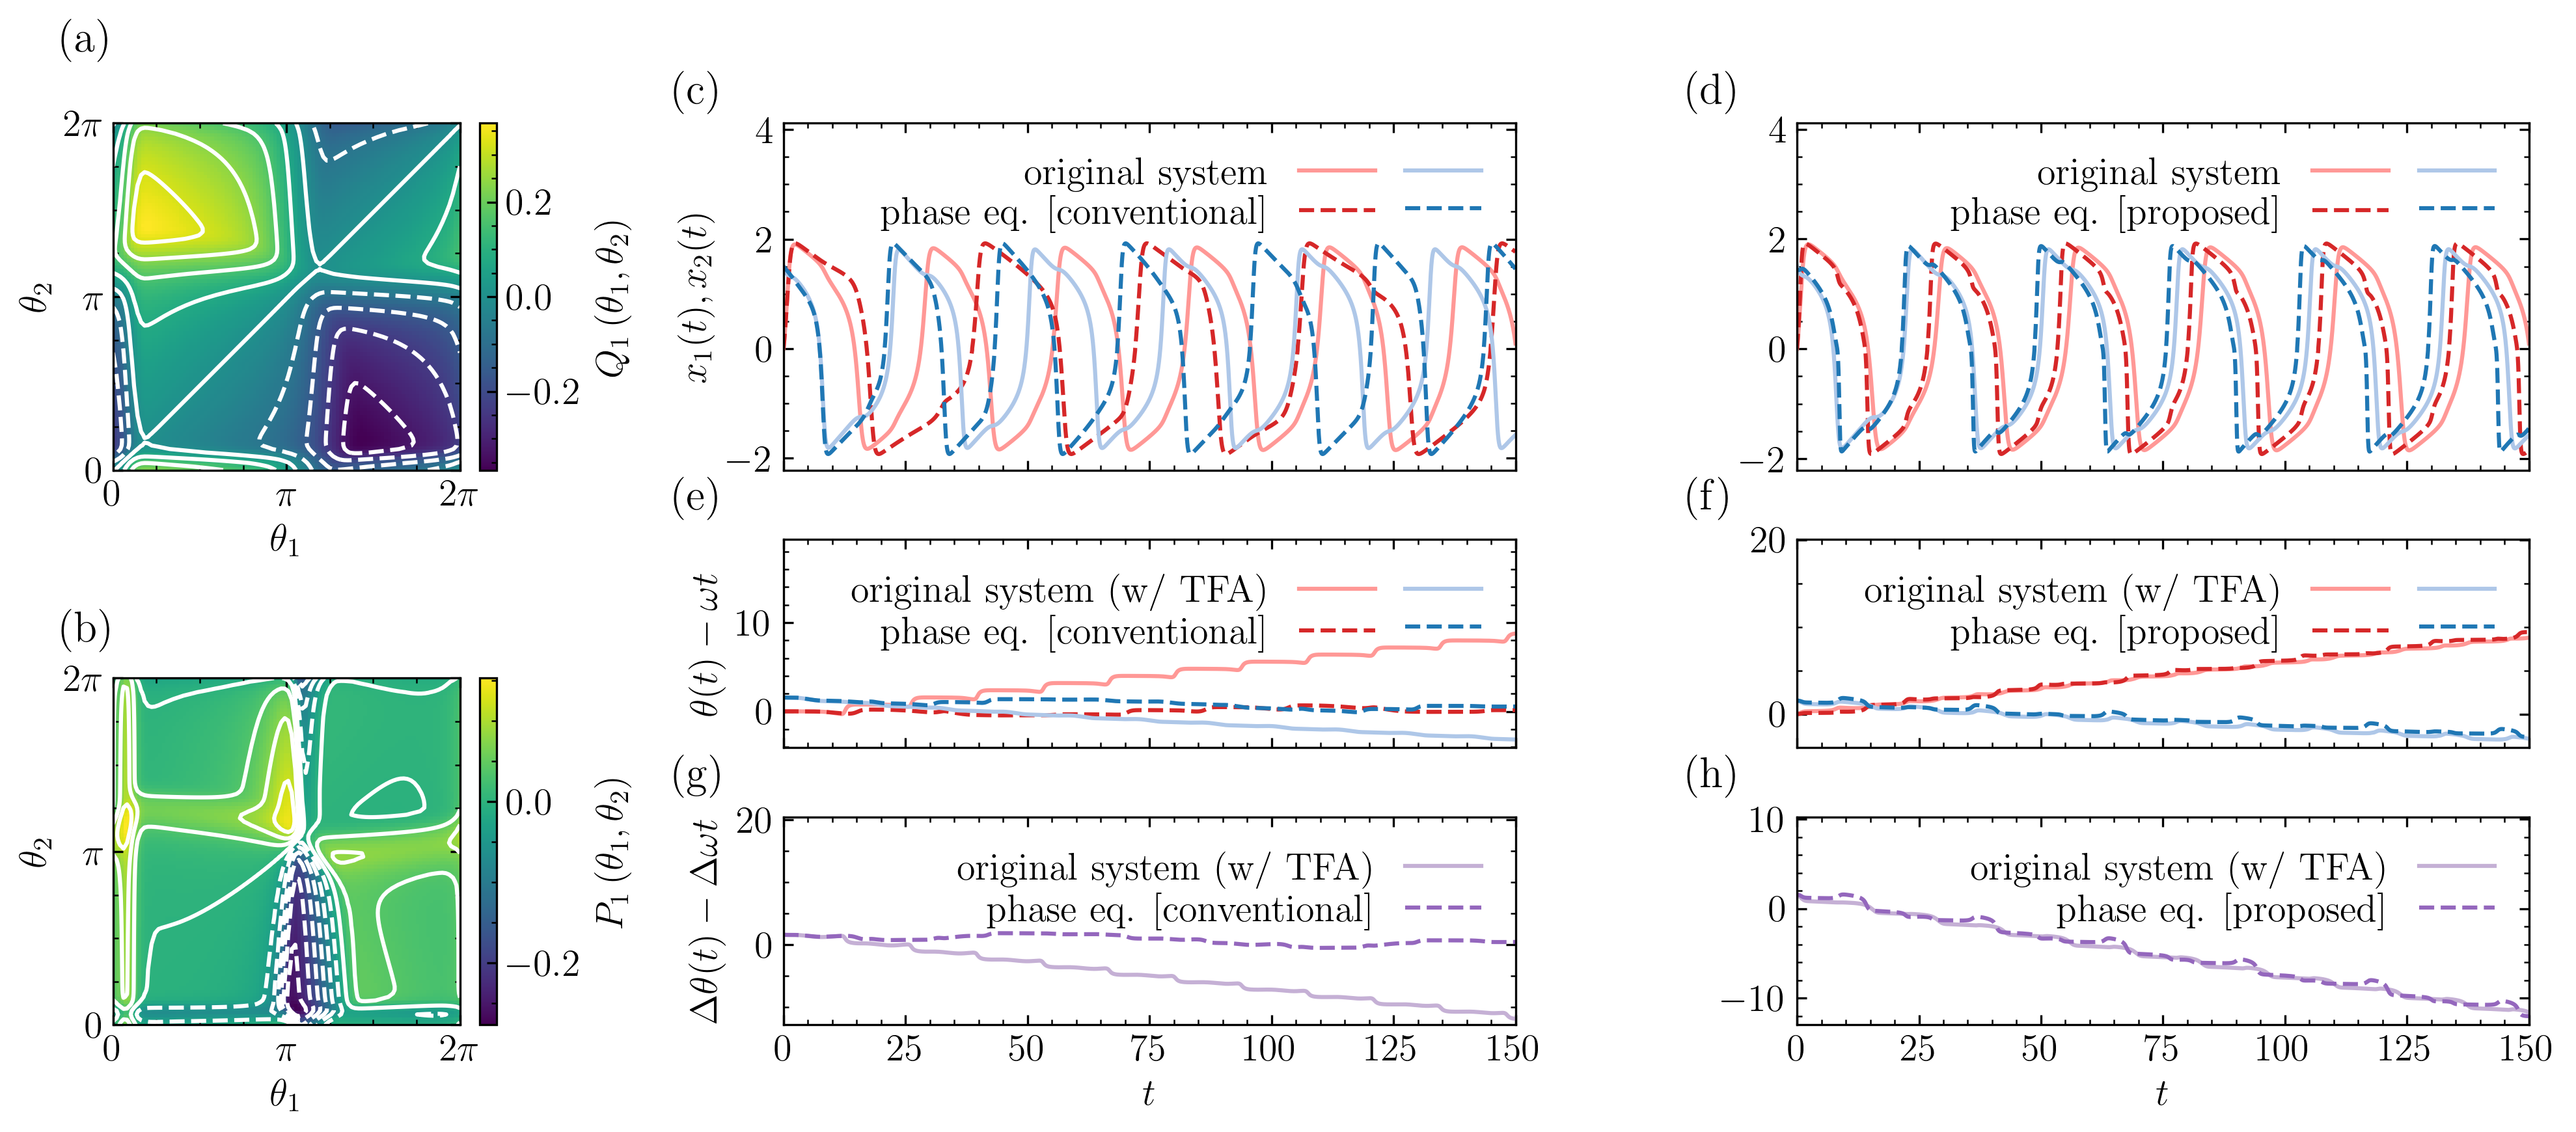

In [150]:
figure(figsize=(16, 6), dpi=300)
gca().set_rasterization_zorder(1)
#### left ####
ax7 = subplot2grid((7, 8), (0, 0), rowspan=3, colspan=2)
contour(Θrange, Θrange, QΘmap, 10, colors="white")
imshow(reverse(QΘmap, dims=1), extent=(0, 2pi, 0, 2pi))
xlabel(L"$\theta_1$"); ylabel(L"$\theta_2$");
xticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
yticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
divider7 = axes_grid1.make_axes_locatable(ax7)
cax7 = divider7.append_axes("right", size="5%", pad=0.1)
cbar7 = colorbar(cax=cax7)
cbar7.set_label(L"$Q_1\left(\theta_1, \theta_2\right)$")
ax7.text(-0.15, 1.3, "(a)", fontsize=16, transform=ax7.transAxes, fontweight="bold", va="top")

ax9 = subplot2grid((7, 8), (4, 0), rowspan=3, colspan=2)
contour(Θrange, Θrange, PΘmap, 10, colors="white")
imshow(reverse(PΘmap, dims=1), extent=(0, 2pi, 0, 2pi))
xlabel(L"$\theta_1$"); ylabel(L"$\theta_2$");
xticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
yticks([0, pi, 2pi], ["0", L"$\pi$", L"$2\pi$"]);
divider9 = axes_grid1.make_axes_locatable(ax9)
cax9 = divider9.append_axes("right", size="5%", pad=0.1)
cbar9 = colorbar(cax=cax9)
cbar9.set_label(L"$P_1\left(\theta_1, \theta_2\right)$")
ax9.text(-0.15, 1.2, "(b)", fontsize=16, transform=ax9.transAxes, fontweight="bold", va="top")

#### middle ####
ax1 = subplot2grid((7, 8), (0, 2), rowspan=3, colspan=3)
# title("Conventinal phase model")
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tcpm, Xcpm[:, 1, 1], "--", label="phase eq. [conventional]", color=cm(6))
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tcpm, Xcpm[:, 2, 1], "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.1, ylim()[2]+2); ylabel(L"$x_1(t), x_2(t)$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax1.text(-0.15, 1.15, "(c)", fontsize=16, transform=ax1.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax3=subplot2grid((7, 8), (3, 2), rowspan=2, colspan=3)
plot(Tos, Θcfa[:, 1]-ωt1os, label="original system (w/ TFA)", color=cm(7))
plot(Tcpm, Θcpm[:, 1]-ωt1cpm, "--", label="phase eq. [conventional]", color=cm(6))
plot(Tos, Θcfa[:, 2]-ωt2os, label=" ", color=cm(1)) 
plot(Tcpm, Θcpm[:, 2]-ωt2cpm, "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+10); ylabel(L"$\theta(t)-\omega t$"); 
plt.gca().axes.xaxis.set_ticklabels([])
ax3.text(-0.15, 1.3, "(e)", fontsize=16, transform=ax3.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax5=subplot2grid((7, 8), (5, 2), rowspan=2, colspan=3)
plot(Tos, Θcfa[:, 2]-Θcfa[:, 1]-Δωtos, label="original system (w/ TFA)", color=cm(9))
plot(Tcpm, Θcpm[:, 2]-Θcpm[:, 1]-Δωtcpm, "--", label="phase eq. [conventional]", color=cm(8))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+18); ylabel(L"$\Delta \theta(t)-\Delta \omega t$"); xlabel(L"$t$");
ax5.text(-0.15, 1.3, "(g)", fontsize=16, transform=ax5.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

#### right ####
ax2=subplot2grid((7, 8), (0, 5), rowspan=3, colspan=3)
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tgpm, Xgpm[:, 1, 1], "--", label="phase eq. [proposed]", color=cm(6))
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tgpm, Xgpm[:, 2, 1], "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.1, ylim()[2]+2);  
plt.gca().axes.xaxis.set_ticklabels([])
ax2.text(-0.15, 1.15, "(d)", fontsize=16, transform=ax2.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax4=subplot2grid((7, 8), (3, 5), rowspan=2, colspan=3)
plot(Tos, Θgfa[:, 1]-ωt1os, label="original system (w/ TFA)", color=cm(7))
plot(Tgpm, Θgpm[:, 1]-ωt1gpm, "--", label="phase eq. [proposed]", color=cm(6))
plot(Tos, Θgfa[:, 2]-ωt2os, label=" ", color=cm(1)) 
plot(Tgpm, Θgpm[:, 2]-ωt2gpm, "--", label=" ", color=cm(0))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+10); 
plt.gca().axes.xaxis.set_ticklabels([])
ax4.text(-0.15, 1.3, "(f)", fontsize=16, transform=ax4.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

ax6=subplot2grid((7, 8), (5, 5), rowspan=2, colspan=3)
plot(Tos, Θgfa[:, 2]-Θgfa[:, 1]-Δωtos, label="original system (w/ TFA)", color=cm(9))
plot(Tgpm, Θgpm[:, 2]-Θgpm[:, 1]-Δωtgpm, "--", label="phase eq. [proposed]", color=cm(8))
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+8); 
xlabel(L"$t$");
ax6.text(-0.15, 1.3, "(h)", fontsize=16, transform=ax6.transAxes, fontweight="bold", va="top")
legend(loc="upper right", ncol=1, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

subplots_adjust(hspace=1, wspace=5)
#show()
#savefig("fig3.svg")

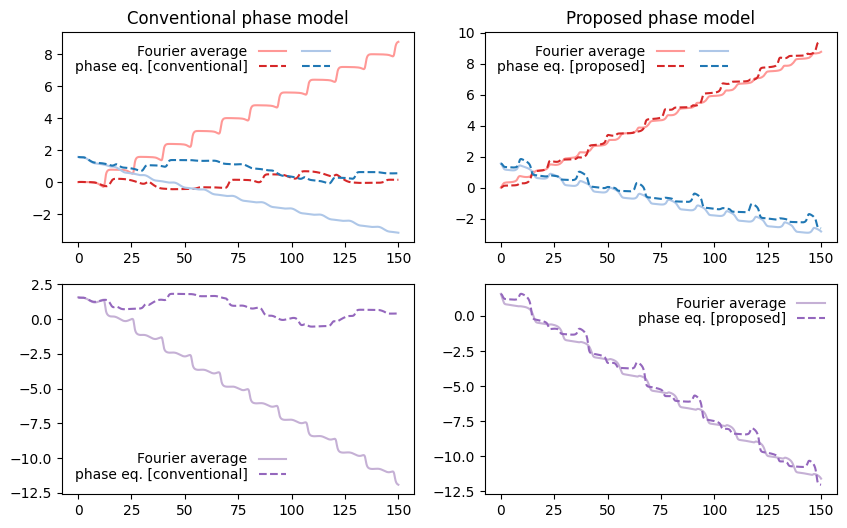

PyObject <matplotlib.legend.Legend object at 0x00000000FA2ADE80>

In [95]:
figure(figsize=(10, 6))
subplot(2,2,1)
title("Conventional phase model")

plot(Tos, Θcfa[:, 1]-ωt1os, label="Fourier average", color=cm(7))
plot(Tcpm, Θcpm[:, 1]-ωt1cpm, "--", label="phase eq. [conventional]", color=cm(6))
plot(Tos, Θcfa[:, 2]-ωt2os, label=" ", color=cm(1))
plot(Tcpm, Θcpm[:, 2]-ωt2cpm, "--", label=" ", color=cm(0))
legend(ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

subplot(2,2,2)
title("Proposed phase model")
plot(Tos, Θgfa[:, 1]-ωt1os, label="Fourier average", color=cm(7))
plot(Tgpm, Θgpm[:, 1]-ωt1gpm, "--", label="phase eq. [proposed]", color=cm(6))
plot(Tos, Θgfa[:, 2]-ωt2os, label=" ", color=cm(1))
plot(Tgpm, Θgpm[:, 2]-ωt2gpm, "--", label=" ", color=cm(0))
legend(ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

subplot(2,2,3)
plot(Tos, Θcfa[:, 2]-Θcfa[:, 1]-Δωtos, label="Fourier average", color=cm(9))
plot(Tcpm, Θcpm[:, 2]-Θcpm[:, 1]-Δωtcpm, "--", label="phase eq. [conventional]", color=cm(8))
legend(labelspacing=0.1, frameon=false, markerfirst=false)

subplot(2,2,4)
plot(Tos, Θgfa[:, 2]-Θgfa[:, 1]-Δωtos, label="Fourier average", color=cm(9))
plot(Tgpm, Θgpm[:, 2]-Θgpm[:, 1]-Δωtgpm, "--", label="phase eq. [proposed]", color=cm(8))
legend(labelspacing=0.1, frameon=false, markerfirst=false)

#ylim(0, 6)

In [131]:
function phase2state_conventional(D, Θ, XsI)
    Nt, N = size(Θ)
    X = zeros(Nt, N, D);
    for tt in 1:Nt
        for i in 1:N
            X[tt, i, :] = [XsI[j](mod(Θ[tt, i], 2π), 0) for j in 1:D] # memory
        end
    end    
    return X
end

phase2state_conventional (generic function with 1 method)

In [132]:
function phase2state_generalized_PQ(D, Θ, XsI, QΘ)
    Nt, N = size(Θ)
    X = zeros(Nt, N, D);
    for tt in 1:Nt
        θ = mod.(Θ[tt, :], 2π)
        q̂ = [QΘ[i](θ...) for i in 1:N]
        Iext = g(hcat([[XsI[j](θ[i], q̂[i]) for j in 1:D] for i in 1:N]...)')
        for i in 1:N
            X[tt, i, :] = [XsI[j](θ[i], Iext[i]) for j in 1:D]
        end
    end       
    return X
end

phase2state_generalized_PQ (generic function with 1 method)

In [133]:
Xcfa = phase2state_conventional(D, Θcfa, XsI);

In [135]:
Xgfa = phase2state_generalized_PQ(D, Θgfa, XsI, QΘ);

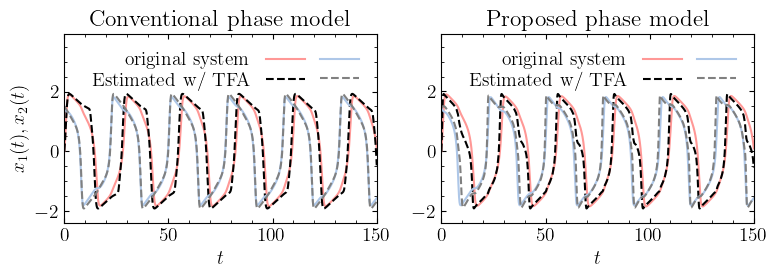

In [161]:
figure(figsize=(8, 3))
subplot(1,2,1)
title("Conventional phase model")
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tos, Xcfa[:, 1, 1], "--", label="Estimated w/ TFA", color="k")
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tos, Xcfa[:, 2, 1], "--", label=" ", color="gray")
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+1.8); ylabel(L"$x_1(t), x_2(t)$"); xlabel(L"$t$"); 
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

subplot(1,2,2)
title("Proposed phase model")
plot(Tos, Xos[:, 1, 1], label="original system", color=cm(7))
plot(Tos, Xgfa[:, 1, 1], "--", label="Estimated w/ TFA", color="k")
plot(Tos, Xos[:, 2, 1], label=" ", color=cm(1))
plot(Tos, Xgfa[:, 2, 1], "--", label=" ", color="gray")
xlim(0, T); ylim(ylim()[1]-0.3, ylim()[2]+1.8); xlabel(L"$t$"); 
legend(loc="upper right", ncol=2, columnspacing=0, labelspacing=0.1, frameon=false, markerfirst=false)

tight_layout()